In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
from numpy import random as rng
from sklearn.utils import shuffle
import pickle
import time

from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K

In [2]:
image_train_dir = '/kaggle/input/omniglot/images_background'
image_eval_dir = '/kaggle/input/omniglot/images_evaluation'

In [3]:
def load_data(dir_path):
    X = []
    y = []
    lang_dict = {}
    classNo = 0
    for alphabet in tqdm(sorted(os.listdir(dir_path))):
        lang_dict[alphabet] = [classNo,None]
        alpha_path = os.path.join(dir_path,alphabet)
        for letter in sorted(os.listdir(alpha_path)):
            cat_images= []
            for img in sorted(os.listdir(os.path.join(alpha_path,letter))):
                img_path = os.path.join(alpha_path,letter,img)
                cat_images.append(cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY))
                y.append(classNo)
            classNo += 1
            X.append(cat_images)
            lang_dict[alphabet][1] = classNo-1
    X = np.array(X)
    y = np.array(y)
#     print(X.shape,y.shape)
    return X, y, lang_dict

In [4]:
trainImages,trainLabels,lang_dict = load_data(image_train_dir)
valImages,valLabels,lang_dictVal = load_data(image_eval_dir)

100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


In [5]:
trainImages.shape, trainLabels.shape

((964, 20, 105, 105), (19280,))

In [6]:
def get_batch(batch_size,dset='train'):
    if dset == 'train':
        X = trainImages
    else:
        X = valImages
    n_classes, n_examples, w, h = X.shape
    cat = rng.choice(n_classes, size=batch_size, replace=False)
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    pairs = [np.zeros((batch_size,w,h,1)) for _ in range(2)]
    for i in range(batch_size):
        ex_no = rng.randint(n_examples)
        pairs[0][i,:,:,:] = X[cat[i],ex_no,:,:].reshape(w,h,1)
        cat2 = 0
        if i >= batch_size // 2:
            cat2 = cat[i]
        else:
            cat2 = (cat[i] + rng.randint(1,n_classes)) % n_classes
        ex_no2 = rng.randint(n_examples)
        pairs[1][i,:,:,:] = X[cat2,ex_no2,:,:].reshape(w,h,1)
    return pairs,targets

In [7]:
# def generate(batch_size=16,dset='train'):
#     while True:
#         pairs,targets = get_batch(batch_size,dset)
#         yield (pairs,targets)

In [8]:
def make_one_shot_task(N,dset='val'):
    if dset == 'train':
        X = trainImages
    else:
        X = valImages
    n_classes, n_examples, w, h = X.shape
    cats = rng.choice(n_classes,size=(N,))
    indices = rng.choice(n_examples,size=(N,))
    true_cat = cats[0]
    ex1 = rng.randint(n_examples)
    test_image = np.array([X[true_cat,ex1]]*N).reshape(N,w,h,1)
    support_set = X[cats,indices].reshape(N,w,h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    
    test_image,support_set,targets = shuffle(test_image,support_set,targets)
    
    return [test_image,support_set], targets

In [9]:
def test_one_shot(model,N,k,dset='val'):
    n_correct = 0
    for _ in range(k):
        inputs, outputs = make_one_shot_task(N,dset)
        preds = model.predict(inputs)
        if np.argmax(outputs) == np.argmax(preds):
            n_correct += 1
    return n_correct / k

# Siamese Network

In [10]:
def get_siamese(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(64,(5,5),input_shape=input_shape,activation='relu',kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512,activation='sigmoid',kernel_regularizer='l2'))
    
    left_emb = model(left_input)
    right_emb = model(right_input)
    
    L1_Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb,right_emb])
    OP = Dense(1,activation='sigmoid',kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=OP)
    
    return siamese_net

In [11]:
num_iterations = 7000
batch_size = 128

evaluateEvery = 100
# Calculate 250 20-way validation testing
k = 250
N = 20

n_classes, n_examples, w, h = trainImages.shape

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=4000,
    decay_rate=0.0001)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = get_siamese((w, h, 1))

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          5926528     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           sequential[1][0]             

In [12]:
lossArr = []
trainAccArr = []
valAccArr = []
currTime = time.time()
for i in range(0,num_iterations+1):
    x,y = get_batch(batch_size)
    loss = model.train_on_batch(x,y)
    if i % evaluateEvery == 0:
        lossArr.append(loss[0])
        trainAcc = round(test_one_shot(model,N,k,'train') * 100,2)
        valAcc = round(test_one_shot(model,N,k,'val') * 100,2)
        trainAccArr.append(trainAcc)
        valAccArr.append(valAcc)
        print('Iteration',i,'('+str(round(time.time() - currTime,1))+'s) - Loss:',loss[0],'Acc:',round(loss[1],2),'',end='')
        print(k,str(N)+'-way train accuracy:', trainAcc,'%, ',end='')
        print(k,str(N)+'-way val accuracy:', valAcc,'%')
        currTime = time.time()

Iteration 0 (23.7s) - Loss: 12.6741295 Acc: 0.48 250 20-way train accuracy: 6.8 %, 250 20-way val accuracy: 5.2 %
Iteration 100 (31.0s) - Loss: 7.7933993 Acc: 0.78 250 20-way train accuracy: 28.8 %, 250 20-way val accuracy: 28.0 %
Iteration 200 (30.6s) - Loss: 7.739346 Acc: 0.78 250 20-way train accuracy: 41.6 %, 250 20-way val accuracy: 37.2 %
Iteration 300 (30.9s) - Loss: 6.463683 Acc: 0.81 250 20-way train accuracy: 43.6 %, 250 20-way val accuracy: 42.0 %
Iteration 400 (31.1s) - Loss: 3.3307781 Acc: 0.79 250 20-way train accuracy: 40.0 %, 250 20-way val accuracy: 35.2 %
Iteration 500 (30.8s) - Loss: 2.6651623 Acc: 0.76 250 20-way train accuracy: 46.0 %, 250 20-way val accuracy: 36.4 %
Iteration 600 (30.2s) - Loss: 1.7577056 Acc: 0.76 250 20-way train accuracy: 46.0 %, 250 20-way val accuracy: 38.8 %
Iteration 700 (30.4s) - Loss: 1.2595501 Acc: 0.77 250 20-way train accuracy: 52.4 %, 250 20-way val accuracy: 43.2 %
Iteration 800 (30.4s) - Loss: 1.1224725 Acc: 0.86 250 20-way train ac

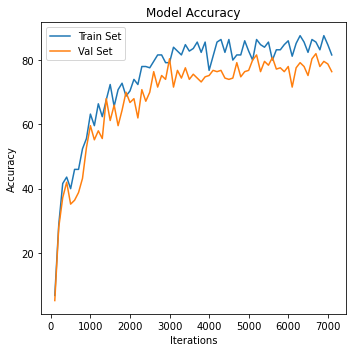

In [13]:
epochs_range = [i*evaluateEvery for i in range(1, len(trainAccArr) + 1)]

plt.figure(figsize=(5,5))

plt.plot(epochs_range, trainAccArr, label='Train Set')
plt.plot(epochs_range, valAccArr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.tight_layout()
plt.show()

In [14]:
print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(model,N,k,'val') * 100,2))

Final Validation Accuracy using 250 20-Way One Shot Learning: 76.0


In [15]:
model.save('omniglot-siamese.h5')